**Authors: Shreyas,Shrushti**

#Introduction:
Sponsorships are pieces of content that have been financed in whole or in part by a third party. Sponsorships generally promote the brand, message or product of the third party without integrating the brand, message, or product directly into the content. They take up 15-60 seconds of the video and can be present multiple times too!
Our aim in this to devise a fastest and most accurate method for distinguishing the sponsor segments on YouTube by using the subtitles of the video. The reason for using this approach is because of availability of a large public dataset through which we can scrape the required data and train on it efficiently.This approach would eventually aid in constructing an algorithm for blocking/removing sponsored segments from the view.

Eg:
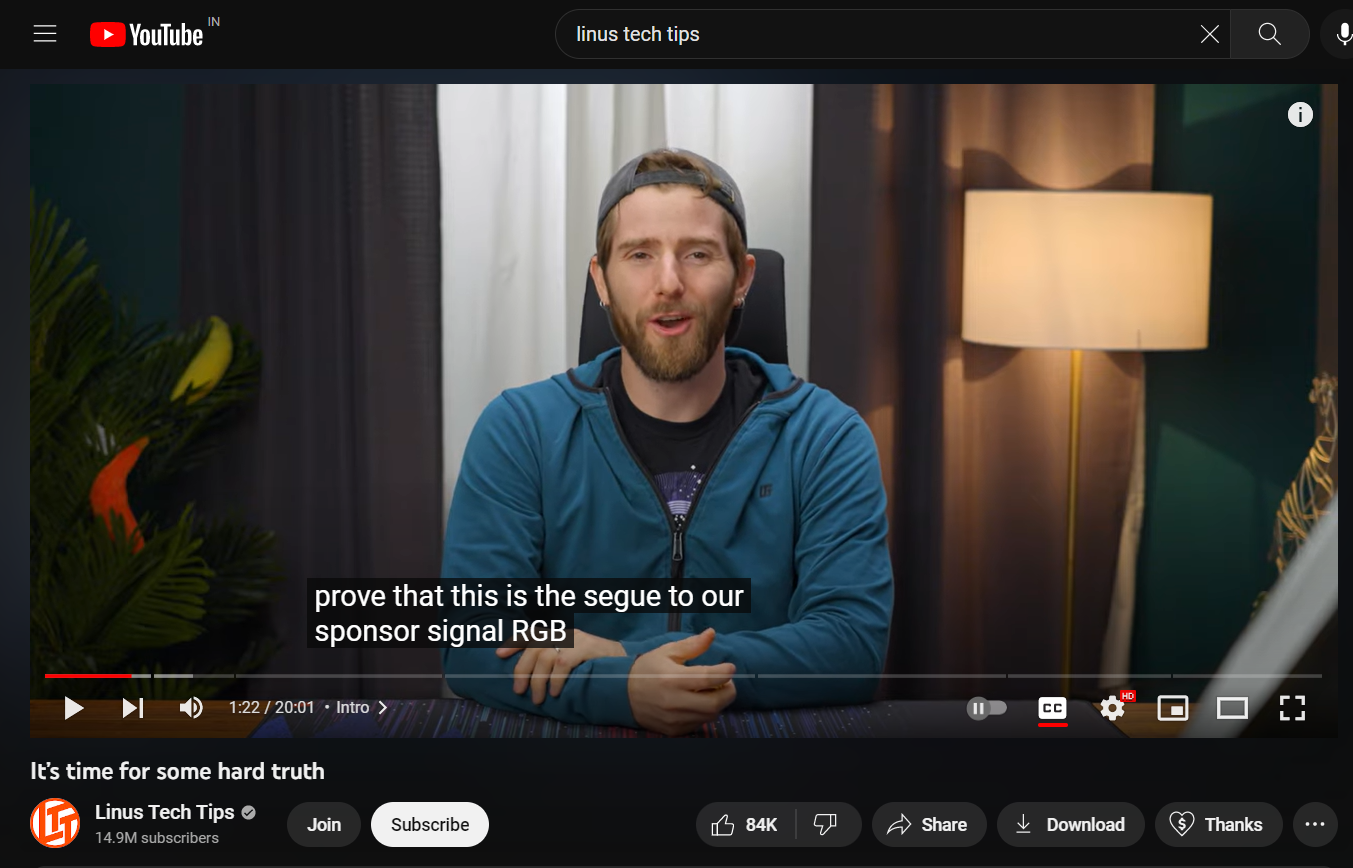

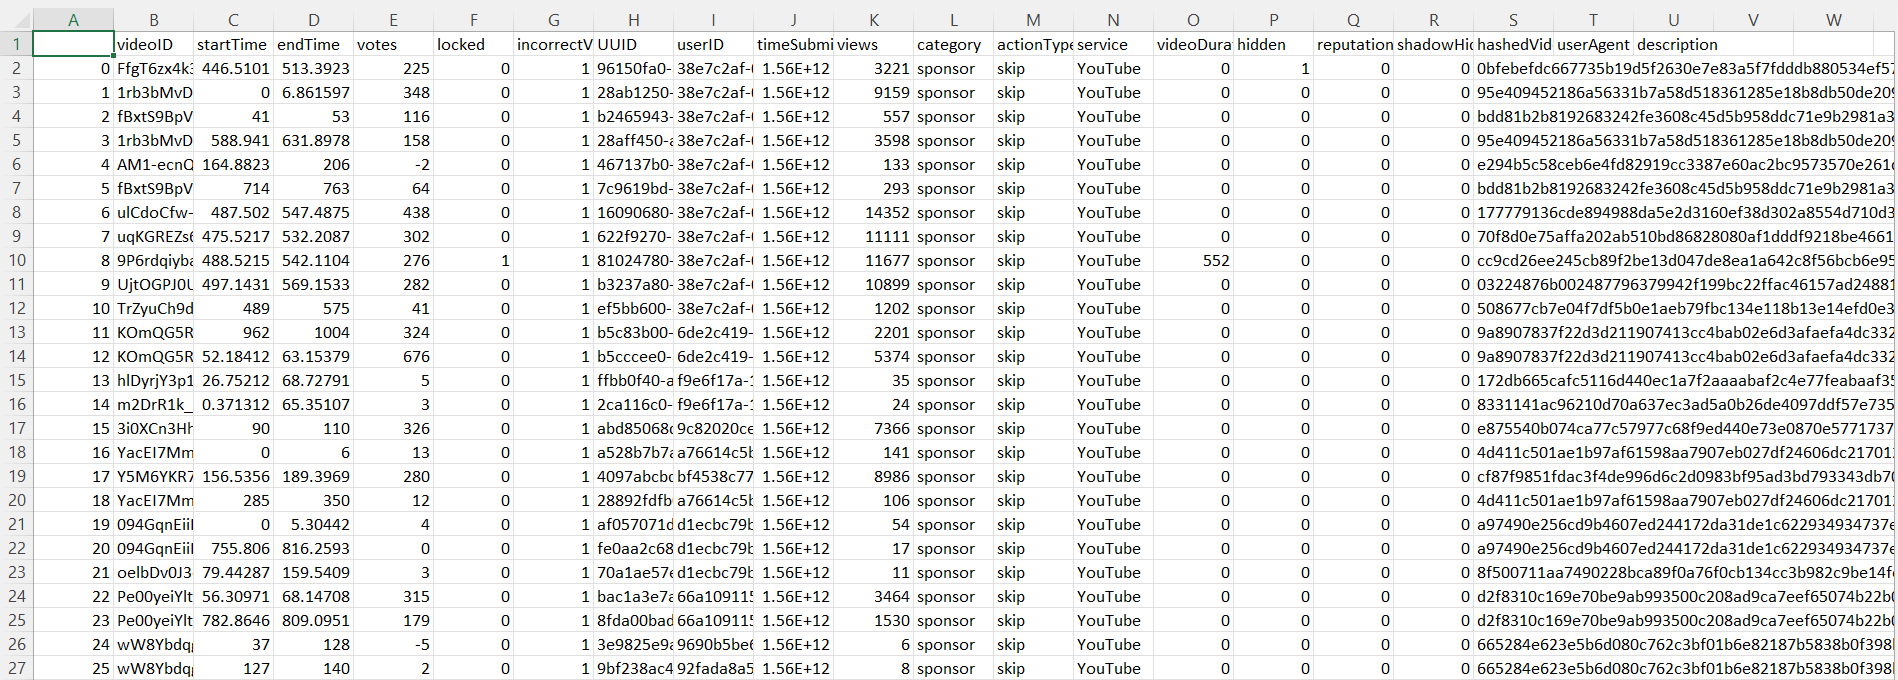

In [ ]:
#LOGGER
import sys

from termcolor import colored

# Basic logging infrastructure. Simpler than the python 'logging' module.
def info(message):
    print(colored(message, 'blue'), file=sys.stderr)
def warn(message):
    print(colored(message, 'yellow'), file=sys.stderr)
def error(message):
    print(colored(message, 'red'), file=sys.stderr)

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install yt_dlp

In [ ]:
import os
import threading
import pandas as pd
import numpy as np
import time

sponsor_times = pd.read_csv('/content/drive/MyDrive/PROJECT/0part.csv', sep=',')
sponsor_times.head()

number_of_entries = len(sponsor_times['category'])

for category in set(sponsor_times['category']):
    count = np.count_nonzero(sponsor_times['category'] == category)
    print(f'{category}: {count}/{number_of_entries} ({count / number_of_entries * 100})')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


poi_highlight: 90940/3699847 (2.4579394769567497)
moreCategories: 4/3699847 (0.00010811257870933582)
sponsor: 1194642/3699847 (32.28895681361959)
filler: 33396/3699847 (0.9026319196442447)
outro: 613052/3699847 (16.569658150728937)
selfpromo: 322032/3699847 (8.703927486731208)
music_offtopic: 152804/3699847 (4.130008619275338)
interaction: 340254/3699847 (9.196434339041588)
preview: 65203/3699847 (1.7623161173962059)
intro: 886386/3699847 (23.957369047963333)
exclusive_access: 1134/3699847 (0.030649916064096706)


In [ ]:
#keep vid id
import pandas as pd

# Filters the csv so that only the videoID column is preserved.
sponsor_times = pd.read_csv('/content/drive/MyDrive/PROJECT/0part.csv', sep=',')
video_ids = sponsor_times[['videoID']]
video_ids = video_ids[sponsor_times['category'] == 'sponsor']
video_ids.to_csv('/content/0parti.csv') #temp csv

In [ ]:
#main.py
from concurrent.futures import thread
from glob import glob
import os
import sys
import multiprocessing.dummy
import subprocess
from sys import stdout
import threading
import pandas as pd
import time
import numpy as np
import yt_dlp
from yt_dlp import DownloadError, SameFileError

def get_or_default(arr, i, default):
	return arr[i] if i < len(arr) else default

# File with column 'videoID'
INPUT_FILENAME = '/content/testparti.csv'
# File to use to save job state
STATUS_FILENAME = '/content/status.csv'
# Directory to store downloaded captions in
OUTPUT_PATH = '/content/sponsor'
# Number of concurrent yt-dlp scripts to run
NUM_THREADS = int('32')

# Runtime stats to display progress
processed = 0
gold = 0
silver = 0
start = time.time()
# Synchronisation for the variables above and the STATUS_FILENAME
lock = threading.Lock()

# Save the output streams -- we redirect sys.stdout/stderr to /dev/null
# to hide the output from yt_dlp
_real_stdout = sys.stdout
_real_stderr = sys.stderr

# Convenience wrapper for print which prints to the real stdout handle
def _print(*args, **kwargs):
    print(*args, **kwargs, file=_real_stdout)

# Pipe to /dev/null
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

try:
    # Try to restore the state from last time
    results = pd.read_csv(STATUS_FILENAME, index_col=False)
    _print('Continuing...')
except:
    results = pd.DataFrame(columns=['videoID', 'status', 'details'])

processed_last_session = len(results['videoID'])

def download_en_captions(vid_id, output_path):
    """
    Downloads the English language captions for the video.

    Returns the tuple `(status: 'gold'|'silver'|'none', message: str)`
    """
    url = f'https://www.youtube.com/watch?v={vid_id}'

    try:
        # Call into yt_dlp
        yt_dlp._real_main([
            # Use IPv4
            "-4",
            # Output filename template
            "-o", output_path + "/%(id)s.%(ext)s",
             # Do not download the video itself
            "--skip-download",
            # Download all available English language captions
            "--write-sub",
            "--sub-lang", "en,en-AU,en-BZ,en-CA,en-IE,en-JM,en-NZ,en-ZA,en-TT,en-GB,en-US",
            url
        ])
    except Exception:
        # We detect failure by checking for the file itself.
        pass
    except SystemExit:
        # When the download fails, yt_dlp calls exit(code).
        pass

    # Check for the output files (if any).
    files = glob(f'{output_path}/{vid_id}.*')
    if len(files) > 0:
        # Keep only the first result (in alphabetical order ~ *.en.*)
        for file in files[1:]:
            os.remove(file)
        return 'gold', ''
    else:
        # Nothing was downloaded, we still need to check for
        # auto-generated captions.
        error = None
        try:
            # Use the same options as above
            yt_dlp._real_main([ "-4", "-o", output_path + "/%(id)s.%(ext)s","--skip-download","--write-auto-sub",
                "--sub-lang", "en", url])
        except DownloadError:
            error = f'Download error!'
        except SameFileError as e:
            error = str(e)
        except SystemExit:
            pass

        files = glob(f'{output_path}/{vid_id}.*')
        if len(files) > 0:
            return 'silver', ''
        else:
            return 'none', error

def process_video(vid_id, output_path):
    """
    Downloads the captions for the video to the output
    path save the job state to disk.
    """
    global gold
    global silver
    global processed

    try:
        status, details = download_en_captions(vid_id, output_path)
        if status == 'gold':
            gold += 1
        if status == 'silver':
            silver += 1
        with lock:
            results.loc[len(results.index)] = [vid_id, status, details]
    except Exception as e:
        _print(e)
        return
    processed += 1

sponsor_times = pd.read_csv(INPUT_FILENAME, sep=',', index_col=False)
video_ids = sponsor_times['videoID'].unique()
np.random.shuffle(video_ids)
video_ids = set(video_ids)

_print(f'Found {len(video_ids)} videos')

if processed_last_session > 0:
    _print(f'{processed_last_session} videos already processed.');
    video_ids = video_ids.difference(set(results['videoID']))

_print(f'{len(video_ids) - processed_last_session} videos remaining')

p = multiprocessing.dummy.Pool(processes=32)

start = time.time()
def _print_progress():
    while True:
        if processed == 0:
            _print('.', end='')
            time.sleep(1)
            continue
        elapsed = time.time() - start
        _print(f"""{processed} videos processed at a rate of {(elapsed / processed):.2f}s per video
            {(gold / processed * 100):.2f}% of videos have GOLD captions, {(silver / processed * 100):.2f}% of videos have SILVER captions
            {((processed + processed_last_session) / len(video_ids) * 100):.2f}% done""")
        with lock:
            results.to_csv(STATUS_FILENAME + '~', index=False)
            os.replace(STATUS_FILENAME + '~', STATUS_FILENAME)
        time.sleep(5)

timer = threading.Thread(target=_print_progress)
timer.start()

p.map(lambda vid_id: process_video(vid_id, OUTPUT_PATH), video_ids)

p.close()
p.join()


Found 70 videos
70 videos remaining
....1 videos processed at a rate of 4.77s per video
            0.00% of videos have GOLD captions, 0.00% of videos have SILVER captions
            1.43% done
2 videos processed at a rate of 5.03s per video
            0.00% of videos have GOLD captions, 0.00% of videos have SILVER captions
            2.86% done
2 videos processed at a rate of 7.66s per video
            0.00% of videos have GOLD captions, 0.00% of videos have SILVER captions
            2.86% done
2 videos processed at a rate of 10.39s per video
            0.00% of videos have GOLD captions, 0.00% of videos have SILVER captions
            2.86% done
3 videos processed at a rate of 8.65s per video
            33.33% of videos have GOLD captions, 0.00% of videos have SILVER captions
            4.29% done
7 videos processed at a rate of 4.49s per video
            28.57% of videos have GOLD captions, 28.57% of videos have SILVER captions
            10.00% done
16 videos processed

In [ ]:
our_data.to_csv("/content/FilteredCombinedCSV.csv")   #FilteredCombinedCSV is concat of csv files containing video id and their subtitle status.

In [ ]:
our_dataii = pd.read_csv("FilteredCombinedCSV.csv" )

In [ ]:
our_dataii.shape

(294834, 2)

In [ ]:
our_dataii["status"].value_counts()

silver    209204
none       50954
gold       34676
Name: status, dtype: int64

In [ ]:
print(our_dataii["status"].isnull().sum())

0


In [ ]:
! pip install webvtt-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=ab24bfc74f28ba02a5b7823ea72b856db72c23440ecc6a78be8a1c19204ce5c3
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [ ]:
import os
import re
import sys
from time import time
from typing import Iterable, Iterator, List, Optional, Tuple
from enum import Enum
from datetime import timedelta
import random

import pandas as pd
import webvtt # webvtt-py

class Caption:
	def __init__(self, start: int, end: int, text: str):
		self.start = start
		self.end = end
		self.text = text
		# self.is_sponsor = False

	def __repr__(self):
		text = self.text.replace('\n', '\\n')   #we remove the esc seq and concat the two lines.
		return f'Caption{{{self.start}:{self.end},{text}}}'

class DBSegment:
	category: str
	startTime: float
	endTime: float
	UUID: str
	userID: str
	votes: int
	views: int
	locked: int
	hidden: int
	shadowHidden: int
	videoID: str
	videoDuration: int
	reputation: int
	hashedVideoID: str
	timeSubmitted: int
	userAgent: str
	service: str
	description: str

class OverlappingSegmentGroup:
	def __init__(self):
		self.segments: List[DBSegment] = []
		self.votes = 0

def get_caption_list_from_path(path: str):
	cap_iter: Iterator[webvtt.Caption] = webvtt.read(path)  #loads the .vtt file from the path
	# The cap_iter may contain overlapping caption regions like below:
	#	<Caption start=00:00:00.060 end=00:00:01.730 text= \nyou know working with tech all the time>
	#	<Caption start=00:00:01.730 end=00:00:01.740 text=you know working with tech all the time\n >
	#	<Caption start=00:00:01.740 end=00:00:03.470 text=you know working with tech all the time\nI sometimes forget that not everyone>
	#	<Caption start=00:00:03.470 end=00:00:03.480 text=I sometimes forget that not everyone\n >
	#	<Caption start=00:00:03.480 end=00:00:05.059 text=I sometimes forget that not everyone\nknows about even the most basic of>
	#	<Caption start=00:00:05.059 end=00:00:05.069 text=knows about even the most basic of\n >
	#	<Caption start=00:00:05.069 end=00:00:07.579 text=knows about even the most basic of\nthings example well the various>
	#	<Caption start=00:00:07.579 end=00:00:07.589 text=things example well the various\n >
	#	<Caption start=00:00:07.589 end=00:00:10.070 text=things example well the various\nstandards of network cables cat 5 versus>
	#	<Caption start=00:00:10.070 end=00:00:10.080 text=standards of network cables cat 5 versus\n >
	# This is how auto-generated captions follow a person's speech.
	# cap[1] replaces cap[0] on-screen and creates a sliding effect.
	# This is fine for YT but not for us.

	# To fix remove the duplication, we check for overlapping parts of text
	# between the captions and eliminate them.
	output: List[Caption] = []
	prev_cap = Caption(start=0, end=0, text="")
	for cap in cap_iter:
		cap = Caption(cap.start_in_seconds, cap.end_in_seconds, cap.text)
		cap.text = clean_text(cap.text)  #clean_text() returns plain text with no punc,

		if cap.text == '':
			continue

		ilen = get_intersection_length(prev_cap.text, cap.text)
		# Is the overlap a whole token or more?
		if ilen > 0 and ilen >= len(cap.text.split(' ', 1)[0]):
			if len(cap.text) == ilen:
				# Remove the whole caption altogether, it is duplicated
				continue
			else:
				# Remove the overlap from this caption
				cap.text = cap.text[ilen:]

		output.append(cap)
		prev_cap = cap

	return output

def get_intersection_length(left: str, right: str):
	"""
	Finds how many characters of overlap is there between left and right.

	```
	left  = "except the various"
	right =            "various forms"
						^^^^^^^
	```
	"""
	i = 0
	while not right.startswith(left[i:]):
		i += 1
	ilen = len(left) - i
	assert ilen == 0 or left[-ilen:] == right[:ilen]
	return ilen

def clean_text(text: str) -> str:
	# Clean italicised quotes
	text = text.replace('\u2019', '\'')
	# Clean HTML and ASCII whitespace
	text = re.sub(r"&nbsp;|\s+", " ", text, flags=re.MULTILINE)
	# Remove markers like [Music], (Intro), special ... and emphasis (*) characters
	text = re.sub(r"\[.+?\]|\(.+?\)|\u2026\*", "", text)
	return text.strip()

def build_segment_groups(segments: List[DBSegment]) -> List[OverlappingSegmentGroup]:
	"""
	This function will find segments that are contained inside of eachother, called similar segments.  (Timestamps)
	Segments with less than -1 votes are already ignored before this function is called.

	Based on https://github.com/ajayyy/SponsorBlockServer/blob/e74b985304443b17b429c5c82696c7a03e78a166/src/routes/getSkipSegments.ts#L276
	"""

	# Create groups of segments that are similar to eachother
	# Segments must be sorted by their startTime so that we can build groups chronologically:
	# 1. As long as the segments' startTime fall inside the currentGroup, we keep adding them to that group
	# 2. If a segment starts after the end of the currentGroup (> cursor), no other segment will ever fall
	#    inside that group (because they're sorted) so we can create a new one
	overlappingSegmentsGroups: List[OverlappingSegmentGroup] = []
	currentGroup = None
	cursor = -1 # -1 to make sure that, even if the 1st segment starts at 0, a new group is created
	for segment in segments:
		if segment.startTime >= cursor:
			currentGroup = OverlappingSegmentGroup()
			overlappingSegmentsGroups.append(currentGroup)

		currentGroup.segments.append(segment)
		# only if it is a positive vote, otherwise it is probably just a sponsor time with slightly wrong time
		if segment.votes > 0:
			currentGroup.votes += segment.votes

		cursor = max(cursor, segment.endTime)

	return overlappingSegmentsGroups

def get_best_segment(group: OverlappingSegmentGroup):
	"""
	SponsorBlock chooses a segment from an overlap group randomly by using the
	votes property as a weight. This is done so that all segments can have a
	chance of appearing and makes sense in that system, but here we just
	want the best possible match, hence we pick the segment with the highest vote.
	"""

	return max(group.segments, key=lambda segment: segment.votes)

def prepare_data(captions_path: str, sponsorml_path: str, output_path: str, vote_threshold: int, chunk_size: int):
	filenames = os.listdir(captions_path)
	print('Reading database...')
	sponsorml_df = pd.read_csv(sponsorml_path)
	rows = []

	start_time = time()

	chunk_id = 0
	def write_chunk():
		nonlocal chunk_id
		nonlocal rows
		chunk_id += 1
		df = pd.DataFrame(rows, columns=['video_id', 'captions', 'sponsor_times'])  # we are initiating pandas df with 3 cols and storing corresponding data in it.
		filename, ext = output_path.rsplit('.json', 1)
		chunk_filename = f'{filename}.{chunk_id}.json{ext}'                                    #writing pandas df to json with chunksize 20,000 per json file.
		df.to_json(chunk_filename, compression='infer', orient='records', lines=True)
		rows = []

	# This is much much faster than doing sponsorml_df[sponsorml_df.videoID == videoID]
	# later. (cut down running time from 12h to 3h)
	grouped_df = sponsorml_df.groupby(by=["videoID"])

	print('Processing captions...')
	for i, filename in enumerate(filenames):                #filenames is basically .vtt caption file path
		progress = (i + 1) / len(filenames) * 100
		elapsed = time() - start_time
		remaining = (100 - progress) * elapsed / progress
		print('\u001b[2K\r', end='')
		print(f'{progress:.2f}% ' +
			f'elapsed: {timedelta(seconds=int(elapsed))}, ' +
			f'remaining: {timedelta(seconds=int(remaining))}',
			end='', flush=True)
		videoID = filename.split('.')[0]         #filenames= [videoid1videoid2]
		# get all labeled segments of video

		segments = grouped_df.get_group(videoID)   #get sponsor segment time stamps fetched from the main public dataset.

		if len(segments) == 0:
			print(f'No segments for {videoID}!')

		# segment filtering
		# https://github.com/ajayyy/SponsorBlockServer/blob/e74b985304443b17b429c5c82696c7a03e78a166/src/routes/getSkipSegments.ts#L18
		segments = [segment for _, segment in segments.iterrows()
			if segment.category == 'sponsor' and segment.votes >= vote_threshold] # TODO: Think about adding a threshold on `views`
		# Filter out similar timestamps
		segments = [get_best_segment(group) for group in build_segment_groups(segments)]

		try:
			captions = get_caption_list_from_path(f'{captions_path}/{filename}')
		except Exception as e:
			e.args = (*e.args, f'while processing {filename}')
			raise e

		segment_times = [(segment.startTime, segment.endTime) for segment in segments]         #we are getting start and end time of sponsor window

		captions_as_tuples = [(cap.text, cap.start, cap.end) for cap in captions]
		rows.append((videoID, captions_as_tuples, segment_times))                              #calling the above explained funcs and storing captions & sponsor segment with start,end times
                                                                                           # {"video_id":"--ABCD","captions":[["Hey....",0.16,6.24],[],[] ],"sponsor_times":[[101.29842,128.87369]]}
		if len(rows) > chunk_size:
			write_chunk()

	if len(rows) > 0:
		write_chunk()

def get_or_default(arr, i, default):
	return arr[i] if i < len(arr) else default

CAPTIONS_PATH = '/content/sponsor'                                                #'/content/captions'
SPONSORML_PATH = '/content/drive/MyDrive/PROJECT/0part.csv'                       #'sponsorTimes.csv'
OUTPUT_PATH = '/content/myfiles/data.json.gz'
VOTE_THRESHOLD = 1 # Higher threshold than minimum (-1) for SponsorBlock
CHUNK_SIZE = 20_000

def main():
	prepare_data(CAPTIONS_PATH, SPONSORML_PATH, OUTPUT_PATH, VOTE_THRESHOLD, CHUNK_SIZE)

if __name__ == '__main__':
	main()


In [ ]:
#DATA-LOADER
from typing import Generator, Iterable, List, Optional, Tuple
from glob import glob
import os
import random

from numpy import isin
import pandas as pd
import torch


MAX_DURATION_PER_TOKEN = 1

# Classes for the sequence classification model
SPONSOR_CLASS = 'sponsor'
CONTENT_CLASS = 'content'

class Caption(dict):
	"""
	A caption line with start and end time in seconds.
	"""
	def __init__(self, start: float, end: float, text: str):
		self['text'] = text
		self['start'] = start
		self['end'] = end

	@property
	def text(self):
		return self['text']

	@text.setter
	def text(self, value):
		self['text'] = value

	@property
	def start(self):
		return self['start']

	@start.setter
	def start(self, value):
		self['start'] = value

	@property
	def end(self):
		return self['end']

	@end.setter
	def end(self, value):
		self['end'] = value

def get_intersection_range(captions: List[dict], start: float, end: float, error: float = 1) -> Tuple[int, int]:
	"""
	Intersects the list of captions with the start and end times of a segment expressed
	in seconds. Allows for an error margin for captions to be considered part of the segment.
	The error margin is also in seconds.
	Returns `(None, None)` if no such sub-list exists.
	"""
	start_caption = None
	for i in range(len(captions)):
		if captions[i]['start'] >= start:  #init start index of caption
			start_caption = i
			break

	if start_caption is None:
		return None, None

	# Apply the error margin
	if start_caption + 1 < len(captions):
		# If the second caption starts very close to the start of the segment,
		# skip over the first caption that was picked originally; it is likely
		# non related to the sponsored content.
		if captions[start_caption + 1]['start'] - start < error:
			start_caption += 1

	end_caption = None
	for i in range(start_caption, len(captions)):
		if captions[i]['start'] >= end:
			end_caption = i
			break

	if end_caption is None:
		return None, None

	# Apply the error margin
	if end_caption - 1 >= 0:                                                               #spons seg [5-10] if our 2nd last cap  appears at 9.8sec
		# If the second to last caption ends very close to the end of the
		# segment, skip over the last caption that was picked originally.
		# It is likely non related to the sponsored content.
		if captions[end_caption - 1]['end'] - end < error:
			end_caption = max(start_caption, end_caption - 1)

	assert start_caption <= end_caption
	return start_caption, end_caption

def tokenize(text: str) -> List[str]:
	"""
	Tokenizes the string.
	"""
	# Split by unicode whitespace.
	return text.split()

def tokenize_caption_list(captions: Iterable[Caption]):
	"""
	Tokenizes the list of captions by splitting captions with multiple tokens
	into separate `Caption` objects. The duration for each token is approximated
	from the duration of the original caption and the length of the work in characters.
	This allows for more accurate token-level extraction to be done.
	Input: 0:0:0 Hello World 0:0:2
	Output: 0:0:0 Hello 0:0:1 World 0:0:2
	"""
	for caption in captions:
		text = caption.text
		tokens = tokenize(text)
		if len(tokens) == 0:
			continue
		if len(tokens) == 1:
			yield Caption(caption.start, caption.end, tokens[0])
			continue

		# Heuristic: Assume the time necessary to pronouce each word depends
		# on the number of characters in that word.
		total_chars = sum(len(token) + 1 for token in tokens)
		time_per_char = (caption.end - caption.start) / total_chars

		current_timestamp = caption.start
		for token in tokens:
			token_duration = min(time_per_char * len(token), MAX_DURATION_PER_TOKEN)
			yield Caption(current_timestamp, current_timestamp + time_per_char * len(token), token)
			current_timestamp += token_duration + time_per_char

def segment_duration(captions: List[Caption]):
	"""
	Returns the duration of the segment in seconds.
	"""
	if len(captions) < 1:
		return 0
	return captions[-1].end - captions[0].start

def segment_text(captions: List[Caption]):
	"""
	Returns the text in the segment.
	"""
	return ' '.join((caption.text for caption in captions))

def forward_time_window(captions: List[Caption], start_index: int, duration: int):
	"""
	Seeks forward for `duration` seconds starting at the start time of the
	caption with index `start_index` the captions are fully contained within
	that time interval.
	"""
	results = [captions[start_index]]
	start_time = captions[start_index].start
	index = start_index + 1
	while index < len(captions) and captions[index].end < start_time + duration:
		results.append(captions[index])
		index += 1

	return results

def backward_time_window(captions: List[Caption], end_index: int, duration: int):
	"""
	Seeks backward for `duration` seconds ending at the start time of the caption
	with index `end_index` and returns the captions are fully contained within
	that time interval.
	"""
	results = [captions[end_index]]
	end_time = captions[end_index].end
	index = end_index - 1
	while index >= 0 and captions[index].start > end_time - duration:
		results.insert(0, captions[index])
		index -= 1

	return results

def extract_labelled_data(video_id, captions, sponsor_ranges):
	"""
	Extracts labelled examples suitable for the training of a binary
	sequence classification model.
	For each video 2*N examples are generated, where N is the number of sponsored
	segments in the video.
	The text of each sponsored segment is matched to other random text in the video
	occuring in a similar time frame (if the sponsored segment is 10s,
	the non-sponsored segment extracted is also 10s).
	"""
	sponsor_segments = []
	content_segments = []

	# Segment the whole video into sponsored and content segments.
	last_sponsor_segment_end = -1
	for start, end in sponsor_ranges:
		sponsor_segments.append(captions[start:end])
		content_segments.append(captions[last_sponsor_segment_end + 1:start])
		last_sponsor_segment_end = end

	# Don't forget the last segment (could be empty, but we check for that later).
	content_segments.append(captions[last_sponsor_segment_end + 1:])

	# Shuffle the content segments before matching sponsor segments to them
	random.shuffle(content_segments)

	for sponsor_segment in sponsor_segments:
		if len(sponsor_segment) == 0:
			continue

		sponsor_duration = segment_duration(sponsor_segment)

		# Match to a non-sponsor segment with the same duration
		found_match = False

		for content_segment in content_segments:
			if segment_duration(content_segment) < sponsor_duration:
				continue

			# Sample either the first N or last N seconds of the segment
			if bool(random.getrandbits(1)):
				short_content_segment = forward_time_window(content_segment, 0, sponsor_duration)
			else:
				short_content_segment = backward_time_window(content_segment, len(content_segment) - 1, sponsor_duration)

			# Yield the two segments
			yield segment_text(sponsor_segment), SPONSOR_CLASS
			yield segment_text(short_content_segment), CONTENT_CLASS

			# Process the next pair
			found_match = True
			break

		if not found_match:
			warn(f'Could not find a non-sponsored segment with the same duration as the sponsored segment for {video_id}')


class GzippedJSONDataset(torch.utils.data.IterableDataset):
	"""
	Reads a .json.gz file.
	"""
	def __init__(self, path: str, subset_length: int = None):
		super().__init__()
		self.path = path
		self.subset_length = subset_length

	def __iter__(self) -> Generator[(str, List[dict], List[Tuple[int, int]])]:
		info(f'Opening {self.path} for reading...')
		count = 0
		with pd.read_json(self.path, orient='record', lines=True, compression='infer', chunksize=500) as reader:
			for chunk in reader:
				for video_id, captions, sponsor_times in chunk.itertuples(index=False, name=None):
					if self.subset_length and self.subset_length < count:
						break
					count += 1
					# Convert from tuples to dicts
					captions = [Caption(start, end, text) for (text, start, end) in captions]
					yield video_id, captions, sponsor_times
		info(f'Closed {self.path}.')

class LabelledCaptionsDataset(torch.utils.data.IterableDataset):
	"""
	An `IterableDataset` which labels and returns the captions from the source
	dataset. Suitable for the training of a sequence labelling model.
	Yields tuples of the form: `video_id, captions, sponsor_ranges`.
	The list of captions is a list of `Caption` with an extra key `is_sponsor`
	indicating whether the caption belongs to a sponsored segment in the video.
	"""

	def __init__(self, dataset: torch.utils.data.IterableDataset):
		super().__init__()
		self.dataset = dataset

	def __iter__(self):
		for video_id, captions, sponsor_times in self.dataset:
			for caption in captions:
				caption['is_sponsor'] = False

			drop_row = False

			sponsor_ranges = []

			for start_time, end_time in sponsor_times:
				# get intersection range and extract the sponsor text from it
				start_index, end_index = get_intersection_range(captions, start_time, end_time)
				if start_index is None or end_index is None:
					print(f'Dropping {video_id} because sponsor times do not match the captions')
					drop_row = True
					break

				# mark range as sponsor
				for i in range(start_index, end_index):
					captions[i]['is_sponsor'] = True

				sponsor_ranges.append([start_index, end_index])

			if len(sponsor_ranges) == 0:
				drop_row = True

			if not drop_row:
				yield video_id, captions, sponsor_ranges

class LabelledExamplesDataset(torch.utils.data.IterableDataset):
	"""
	An `IterableDataset` which samples the video transcripts and yields
	examples of the classes `sponsor` or `content`. Due to how the sampling is
	done, the dataset is always balanced in terms of class labels and sequence
	lengths from both classes.
	Yields tuples of the form: `text, label`.
	See also: `extract_labelled_data`
	"""

	def __init__(self, dataset: torch.utils.data.IterableDataset):
		super().__init__()
		self.dataset = dataset

	def __iter__(self):
		for video_id, captions, sponsor_times in self.dataset:
			captions = list(tokenize_caption_list(captions))
			segment_ranges = [get_intersection_range(captions, start_time - MAX_DURATION_PER_TOKEN, end_time + MAX_DURATION_PER_TOKEN, error=MAX_DURATION_PER_TOKEN) for start_time, end_time in sponsor_times]
			# Filter out broken ranges
			segment_ranges = [r for r in segment_ranges if r[0] is not None and r[1] is not None]

			for text, label in extract_labelled_data(video_id, captions, segment_ranges):
				if len(text) == 0:
					continue
				yield text, label

class LabelledTokensDataset(torch.utils.data.IterableDataset):
	"""
	IterableDataset that tokenizes the transcripts of a given caption dataset
	and labels the tokens according to whether they are included in a sponsor-labeled caption.
	"""

	def __init__(self, dataset, tokenizer):
		super().__init__()
		self.dataset = dataset
		self.tokenizer = tokenizer

	def __iter__(self):
		for video_id, captions, sponsor_times in self.dataset:

			drop_row = False

			sponsor_ranges = []

			for start_time, end_time in sponsor_times:
				# get intersection range and extract the sponsor text from it
				start_index, end_index = get_intersection_range(captions, start_time, end_time)
				if start_index is None or end_index is None:
					print(f'Dropping {video_id} because sponsor times do not match the captions')
					drop_row = True
					break

				# mark range as sponsor
				for i in range(start_index, end_index):
					captions[i]['is_sponsor'] = True

				sponsor_ranges.append([start_index, end_index])

			if not drop_row:
				input_ids = []
				labels = []

				for caption in captions:
					tokenized_caption = self.tokenizer(caption['text'])
					# remove special beginning/end tokens
					input_ids += tokenized_caption['input_ids'][1:-1]

					# label every token accordingly
					label = 1 if 'is_sponsor' in caption else 0
					labels += [label] * len(tokenized_caption['input_ids'][1:-1])

				# flag indicating whether a completely non-sponsor segment has been yielded.
				# limitting the number of fully non-sponsor segments to balance the data
				yielded_non_sponsor = False

				# go through the transcript max_length segment by max_length segment
				for window_start in range(0, len(input_ids), 510):
					w_input_ids = input_ids[window_start:]
					w_labels = labels[window_start:]

					# make sure to yield at most 1 completely non-sponsor segment
					if 1 not in w_labels:
						if yielded_non_sponsor:
							continue
						else:
							yielded_non_sponsor = True

					# add back special tokens
					prepared_tokenizer = self.tokenizer.prepare_for_model(w_input_ids, truncation=True, padding='max_length')

					attention_mask = prepared_tokenizer['attention_mask']

					# loop to deal with special tokens, labelling them with -100 for the BERT model to ignore
					new_labels = []
					for i, m in enumerate(attention_mask):
						if m == 1:
							if i == 0:
								new_labels.append(-100)
							elif i == len(attention_mask) - 1:
								new_labels.append(-100)
							elif i == len(w_input_ids) + 1:
								new_labels.append(-100)
							else:
								new_labels.append(w_labels[i-1])
						else:
							new_labels.append(-100)

					w_input_ids = prepared_tokenizer['input_ids']

					yield {'input_ids': w_input_ids, 'labels': new_labels, 'attention_mask': attention_mask}

	def __len__(self):
		# needed for training, 20001 is the length of every chunk in the caption dataset
		return 20001


def load_data_from_chunks(base_name: str, root_dir: str = '.', chunks: Optional[Iterable[int]] = None):
	"""
	Loads all `data.N.json.gz` files.
	"""
	if chunks is None:
		files = glob(os.path.join(root_dir, f'{base_name}.*.json.gz'))
	else:
		files = [os.path.join(root_dir, f'{base_name}.{chunk}.json.gz') for chunk in chunks]

	if len(files) == 0:
		raise Exception('No matching files found!')

	for file in files:
		if not os.path.exists(file):
			raise FileNotFoundError(file)

	return torch.utils.data.ChainDataset([GzippedJSONDataset(file) for file in files])

def load_captions_from_chunks(base_name: str, root_dir: str = '.', chunks: Optional[Iterable[int]] = None):
	"""
	Loads all `data.N.json.gz` files and labels the individual captions.
	See also: `LabelledCaptionsDataset`
	"""

	return LabelledCaptionsDataset(load_data_from_chunks(base_name, root_dir, chunks))

def load_examples_from_chunks(base_name: str, root_dir: str = '.', chunks: Optional[Iterable[int]] = None):
	"""
	Loads all `data.N.json.gz` files and produces labelled examples.
	See also: `LabelledExamplesDataset`
	"""

	return LabelledExamplesDataset(load_data_from_chunks(base_name, root_dir, chunks))

#Motivation
Several similar projects based on a BERT-type text classification model have been written about in on the Internet. Unfortunately, in both instances the authors do not share details about the performance of the model. Instead, they used vague language like "95% accuracy" without qualifying that in any meaningful way. What is more, the trained models in both instances then demonstrably perform poorly in the downstream task of task classification, but no exact numbers are reported.

We wanted to investigate how well a text classification model can perform on what is essentially a span extraction task.

In [ ]:
! pip install datasets

In [ ]:
!pip install transformers

In [ ]:
#SEQUENCE CLASSIFICATION
import os
import sys

import numpy as np
import torch
from datasets import Dataset, IterableDataset, IterableDatasetDict, ClassLabel, load_dataset, load_from_disk, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import pandas as pd
import pyarrow as pa

sys.path.append(os.path.dirname(os.path.realpath('..')))
#from data_loader import load_examples_from_chunks, load_captions_from_chunks

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#Read the transcripts from the data.N.json.gz and extract examples using load_examples_from_chunks.
LABELS = {'content': 0,'sponsor': 1,}

def load_examples(chunks=None):
    for example, label in load_examples_from_chunks(base_name='data', root_dir='/content/drive/MyDrive/JSON', chunks=chunks):
        yield example, LABELS[label]

def iterable_to_pandas(columns, iterable, max_length):
    from tqdm.auto import tqdm                           #to show progress bar
    df = pd.DataFrame(columns=columns)
    for item in tqdm(iterable, total=max_length):
        df.loc[len(df)] = item

    return df

In [ ]:
#The dataset returned by load_examples_from_chunks is much smaller than the original ~10 GB dataset
#because it does not include full video transcripts. We read this whole thing into memory into a pandas DataFrame
#and then save it to disk for further use. Loading the dataset into memory makes it easier to work with.
import itertools
for x in itertools.islice(load_examples(), 0, 50):               #islice(iterable, start, stop, step) #printing 50 lines
    print(x)


Opening /content/drive/MyDrive/JSON/data.9.json.gz for reading...


('Synergy allows you to share your mouse and keyboard between multiple computers at once. Check it out now at the link in the video description. So, to', 1)
('maybe consider checking out where to buy the stuff we featured at the link in the video description. Also down there is a link to our merch store, where you can buy a cool shirt like this one and our community forum, which you should totally join.', 0)
("Synergy is an easy software download that solves once and for all the problem of having two keyboards and two mice on your desk, if you have multiple PCs, because it lets you share one mouse and one keyboard between two or more computers seamlessly, so you'll no longer confuse which one goes with which. And they even allow advanced features like: clipboard sharing between the computers, being able to drag-and-drop files between the computers, the ability to set up hotkeys and support for multiple operating systems: Windows, Mac, even Linux. They've got basic and pro options and y

In [ ]:
df = iterable_to_pandas(['text', 'label'], load_examples(range(1, 13)), 13 * 20_000)       # 13 json og but now 1-12

  0%|          | 0/260000 [00:00<?, ?it/s]

Opening /content/drive/MyDrive/JSON/data.1.json.gz for reading...
Could not find a non-sponsored segment with the same duration as the sponsored segment for W5nwZ2vQRFo
Could not find a non-sponsored segment with the same duration as the sponsored segment for VGqry4B7htA
Could not find a non-sponsored segment with the same duration as the sponsored segment for Hq8UThZYNzs
Could not find a non-sponsored segment with the same duration as the sponsored segment for iOKXk2FiGh8
Could not find a non-sponsored segment with the same duration as the sponsored segment for 599CrYI9bLk
Could not find a non-sponsored segment with the same duration as the sponsored segment for fQXkokRE8K4
Could not find a non-sponsored segment with the same duration as the sponsored segment for NeOKHSUB6ls
Could not find a non-sponsored segment with the same duration as the sponsored segment for NeOKHSUB6ls
Could not find a non-sponsored segment with the same duration as the sponsored segment for Kg2N8-XPFg8
Closed 

In [ ]:
Dataset.from_pandas(df).remove_columns('__index_level_0__').save_to_disk('/content/drive/MyDrive/classification-dataset')  #removing def index col and making one DS

In [ ]:
#Reading prepped data using huggingface API
raw_datasets = load_from_disk('/content/drive/MyDrive/classification-dataset').train_test_split(test_size=0.2)  #Total 139,668 samples
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 111734
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 27934
    })
})

In [ ]:
raw_datasets['test'][:30]

{'text': ["to thank doordash for sponsoring this stream thanks door - we really appreciate it we're trying our best and you can try your best and continue supporting restaurants in your community safely with door - there are thousands of restaurants open for delivery on door - that need your patron is now more than ever support your favorite restaurants on door - I use door - use door - quite quite a lot especially now I mean I used it before now but there's like hundreds of thousands of you got local restaurants you got chain restaurants you pick what you want to deliver it right to your door they got especially convenient now just like drop-off they just leave it at your door let you know hey it's there you go grab it bing-bang-boom easy door - is the app that brings you food when you're craving it right now right to your door with over 300 thousand partners in the u.s. poured Rico Canada and Australia you can support your local go to or choose from your favorite national restaurants

In [ ]:
df.head                                                   #{'content': 0,'sponsor': 1}

<bound method NDFrame.head of                                                      text label
0       when we can see a hundred petr parkers on one ...     1
1       continued to bend the same line 4 phases in wh...     0
2       quick thank you to the video sponsor nordvpn n...     1
3       you check out the patreon if you want to suppo...     0
4       the exhibition lived itself has already begun ...     1
...                                                   ...   ...
139663  and I look kind of cool. He looks like he's ab...     0
139664  to do at least one. &gt;&gt; How's it going? &...     1
139665  and I look kind of cool. He looks like he's ab...     0
139666  this video is sponsored by brilliant let's say...     1
139667                             guys in the next video     0

[139668 rows x 2 columns]>

In [ ]:
# If we've arrived here, everything with the dataset is okay and it has been stored to disk. We
# can drop the in-memory `DataFrame` we constructed originally.
df = None

In [ ]:
#Tokenize the datatset with the pre-trained tokenizer. Sequences are padded to the maximum length supported by BERT and truncated if longer.
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/28 [00:00<?, ?ba/s]

In [ ]:
cleaned_datasets = tokenized_datasets.remove_columns(['text'])
train_dataset = cleaned_datasets['train']
test_dataset = cleaned_datasets['test']


In [ ]:
#PREPARING FOR TRAINING
torch.cuda.empty_cache()
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/distilbert-classification-uncased",
    per_device_train_batch_size=16,               #48
    per_device_eval_batch_size=16,
    save_total_limit=2,
    save_strategy='epoch',
    evaluation_strategy='epoch')

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **precision, **recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

#Train the model ⚡
We're using the default number of batches, but we terminate the training early because we observe that the model performs extremely well on all metric on the test dataset and because the training loss and validation loss are comparable after step 30,000, indicating that there is not too much over- or under-fitting, and that the model is not likely to learn anything else.

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 111734
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 10476


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.160900,0.161438,0.940932,0.941650,0.939757
2,0.098800,0.159211,0.946016,0.967266,0.922955


***** Running Evaluation *****
  Num examples = 27934
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-3492
Configuration saved in /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-3492/config.json
Model weights saved in /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-3492/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 27934
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984
Configuration saved in /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984/config.json
Model weights saved in /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984/pytorch_model.bin


In [ ]:
trainer.train("/content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984") #continued training  from previous checkpoint after crash

Loading model from /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 111734
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 10476
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 6984
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]

In [ ]:
model = None
trainer = None
trained = None
torch.cuda.empty_cache()

def softmax_outputs(outputs) -> dict:
    return torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()

trained = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984')   #7210   7449
#trained.to('cuda')

loading configuration file /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/distilbert-classification-uncased/checkpoint-6984/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceCla

In [ ]:
import itertools
from collections import defaultdict

"""
This segment of code, helps to load & prevent overlapping and properly format the captions from test data (.json.gz file)

"""

def caption_times(c):
    return c.start, c.end

def prediction_times(p):
    return tuple(p[0])

def tumbling_time_window(captions, duration, key=caption_times):                    #processes each window in a non-overlapping manner
    results = [captions[0]]
    for caption in captions:
        if key(results[-1])[1] - key(results[0])[0] <= duration:                   #caption start and end times are less than duration then append.
            results.append(caption)
        else:
            yield results
            results = [caption]

    yield results

def session_time_window(captions, duration, key=caption_times):
    captions_iter = iter(captions)
    results = [next(captions_iter)]
    for caption in captions_iter:
        if key(results[-1])[1] - key(caption)[0] <= duration:
            results.append(caption)
        else:
            yield results
            results = [caption]

    yield results

def batch(iterable, n):
    length = len(iterable)
    for i in range(0, length, n):
        yield iterable[i:min(i + n, length)]

def decode_label(outputs):
    content, sponsor = outputs

    prediction_dict = {'sponsor': sponsor, 'content': content}
    prediction_dict = {k: v for k, v in sorted(prediction_dict.items(), key=lambda item: item[1], reverse=True)}

    return next(iter(prediction_dict.items()))

def predict_in_batches(texts, batch_size: int = 8):    #batch_size=8
    batches = list(batch(texts, batch_size))
    for b in batches:
        inputs = defaultdict(list)
        for text in b:
            tokenized = tokenize_function({ 'text': text })
            for k, v in tokenized.items():
                inputs[k].append(v)

        inputs = { k: torch.tensor(v).cuda() for k, v in inputs.items() }
        outputs = trained(**inputs)                                                          #logit = numeric output of the last linear layer of a
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1).tolist()           #        multi-class classification neural network
        yield from predictions

def predict_sponsor_segments(captions, window_duration=10):
    windows = list(tumbling_time_window(captions, window_duration))
    window_texts = [segment_text(window) for window in windows]
    predictions = predict_in_batches(window_texts, 4)

    for window, text, prediction in zip(windows, window_texts, predictions):
        yield [window[0].start, window[-1].end], text, decode_label(prediction)  ## *deco

def merge_prediction_(predictions):
    assert len(set((label for _, _, label, _ in predictions))) == 1
    # All co-occurring predictions have the same label so we merge them
    merged_start, merged_end = predictions[0][0][0], predictions[-1][0][1]
    merged_text = ' '.join((text for _, text, _, _ in predictions))
    # Don't know what the correct way to compute the joint probability here is,
    # just assuming they are independent; We don't really use this number anywhere
    prob = np.prod([prob for _, _, _, prob in predictions])
    return [merged_start, merged_end], merged_text, predictions[0][2], prob

def merge_predictions(predictions, within_duration=5):
    for co_occuring in session_time_window(predictions, within_duration, key=prediction_times):
        merged = [co_occuring[0]]
        for times, text, label, prob in co_occuring[1:]:
            _, _, prev_label, _ = merged[0]
            if label == prev_label:
                merged.append((times, text, label, prob))
            else:
                yield merge_prediction_(merged)
                merged = [(times, text, label, prob)]

        if len(merged) > 0:
            yield merge_prediction_(merged)


In [ ]:
import itertools

def range_equals(left: 'Tuple[float, float]', right: 'Tuple[float, float]', eps: float) -> bool:
    left_start, left_end = left
    right_start, right_end = right

    return (abs(left_start - right_start) <= eps
        and abs(left_end - right_end) <= eps)

def count_range_equals(pairs, eps: float) -> int:
    cnt = 0
    for left, right in pairs:
        if range_equals(left, right, eps):
            cnt += 1
    return cnt

assert range_equals([0, 5], [0, 5], eps=0)
assert range_equals([1, 6], [0, 5], eps=1)
assert range_equals([-1, 4], [0, 5], eps=1)
assert not range_equals([-2, 4], [0, 5], eps=1)
assert not range_equals([1, 7], [0, 5], eps=1)

def range_negation(base: 'Tuple[float, float]', ranges: 'List[Tuple[float, float]]') -> 'List[Tuple[float, float]]':
    """
    base:    |-------------|
    ranges:  | ***   **    |
    Return:  |#   ###  ####|
    """
    results = []
    last_end = base[0]
    for r in ranges:
        if last_end != r[0]:
            results.append((last_end, r[0]))
        last_end = r[1]
    if last_end != base[1]:
        results.append((last_end, base[1]))

    return results

assert range_negation((2, 10), [(3,4), (5, 6)]) == [(2, 3), (4, 5), (6, 10)]
assert range_negation((2, 6), [(3,4), (5, 6)]) == [(2, 3), (4, 5)]
assert range_negation((3, 6), [(3,4), (5, 6)]) == [(4, 5)]

In [ ]:
from termcolor import colored

def create_labels_from_range(captions, sponsor_ranges):
    caption_labels = np.zeros(len(captions), dtype=bool)
    for start_idx, end_idx in sponsor_ranges:
        if start_idx is None or end_idx is None:
            continue
        for i in range(start_idx, end_idx + 1):
            caption_labels[i] = True

    token_labels = []
    for i, caption in enumerate(captions):
        num_tokens = len(caption.text.split())
        token_labels.extend([caption_labels[i]] * num_tokens)
    return token_labels

def create_labels_from_times(captions, sponsor_times):
    ranges = [get_intersection_range(captions, *pair[1]) for pair in sponsor_times]
    return create_labels_from_range(captions, ranges)

def evaluate(videos, eps=5, window_duration=10):
    from tqdm.auto import tqdm

    predicted_labels = np.empty(0)
    actual_labels = np.empty(0)
    # Values for our close match metric (exact match with threshold)
    # Number of maches
    close_matches = 0
    # Number of predicted ranges
    total_predicted_ranges = 0

    for video_id, captions, sponsor_ranges in tqdm(videos):
        print(colored(f'{video_id} {sponsor_ranges}', None, 'on_magenta'))
        sponsor_times = [(captions[start].start, captions[end].end) for start, end in sponsor_ranges]
        predicted_sponsor_times = []

        for times, text, label, prob in merge_predictions(predict_sponsor_segments(captions, window_duration), window_duration):
            if label == 'sponsor':
                predicted_sponsor_times.append((f'{int(prob * 100)}%', times))

            color = { 'sponsor': 'yellow', 'content': None }[label]
            # print(colored(f'{int(prob * 100)}% {times[0]} <--> {times[1]} {text}', color=color))

            if any((range_equals(times, actual_times, eps) for actual_times in sponsor_times)):
                close_matches += 1
            total_predicted_ranges += 1

        predicted_sponsor_ranges = [get_intersection_range(captions, *pair[1]) for pair in predicted_sponsor_times]
        predicted_labels = np.append(predicted_labels, create_labels_from_range(captions, predicted_sponsor_ranges))
        actual_labels = np.append(actual_labels, create_labels_from_range(captions, sponsor_ranges))

        print(f'\tPredicted={predicted_sponsor_ranges},\n\tExpected={sponsor_ranges}')

    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve

    close_match_score = close_matches / total_predicted_ranges
    print(f'Exact match (with {eps}s threshold)', close_match_score)
    print('Confusion matrix', confusion_matrix(actual_labels, predicted_labels))
    print('Accuracy', accuracy_score(actual_labels, predicted_labels))
    print('Precision', precision_score(actual_labels, predicted_labels))
    print('Recall', recall_score(actual_labels, predicted_labels))
    print('P@R', precision_recall_curve(actual_labels, predicted_labels))
    print('RoC', roc_curve(actual_labels, predicted_labels))

In [ ]:
test_videos = list(itertools.islice(load_captions_from_chunks('data', '/content/drive/MyDrive/JSON', [12]), 1, 200))

Opening /content/drive/MyDrive/JSON/data.12.json.gz for reading...


Dropping ePO2w0TCuUc because sponsor times do not match the captions
Dropping epqHl3JJkQM because sponsor times do not match the captions
Dropping epqYft12nV4 because sponsor times do not match the captions
Dropping Epr-b77tGXs because sponsor times do not match the captions
Dropping EPTISdvyPiU because sponsor times do not match the captions
Dropping EPuYJTBl_QM because sponsor times do not match the captions
Dropping Epv6HLysQz4 because sponsor times do not match the captions
Dropping EpYW6ffUzng because sponsor times do not match the captions
Dropping ePy_Gs3WTT4 because sponsor times do not match the captions
Dropping EpZxInIMNUw because sponsor times do not match the captions
Dropping Eq6Kpz76FGs because sponsor times do not match the captions
Dropping EqGoJN-zNXk because sponsor times do not match the captions
Dropping EQmjXM4VK2U because sponsor times do not match the captions
Dropping eQo0Goh-XlE because sponsor times do not match the captions
Dropping eqR9ZrkWv0o because spons

In [ ]:
evaluate(
    videos=test_videos,
    window_duration=5,
    eps=5,
)

  0%|          | 0/199 [00:00<?, ?it/s]

YzGt5abcfbA [[21, 46]]
	Predicted=[(38, 40), (230, 236), (352, 355)],
	Expected=[[21, 46]]
YZhRjPrNY4k [[267, 300]]
	Predicted=[(265, 268), (276, 278), (287, 297), (337, 339), (372, 374), (396, 398)],
	Expected=[[267, 300]]
Yzi6lQjLjQ8 [[14, 41]]
	Predicted=[(14, 16), (37, 39), (292, 294), (334, 334)],
	Expected=[[14, 41]]
YzIdXOeqXig [[187, 231]]
	Predicted=[(44, 44), (189, 191), (194, 196), (245, 246), (255, 259), (292, 298)],
	Expected=[[187, 231]]
yZIT6ZtsNxI [[156, 196]]
	Predicted=[(124, 125), (176, 179), (184, 186), (189, 190), (225, 226), (268, 271), (372, 376), (435, 436), (596, 599), (839, 840), (959, 963), (1009, 1012), (1148, 1151), (1206, 1207), (1258, 1262)],
	Expected=[[156, 196]]
yzj6iuYIQVM [[145, 194]]
	Predicted=[(0, 5), (145, 148), (155, 166), (184, 193), (543, 546)],
	Expected=[[145, 194]]
YZJjFsAxN7s [[9, 32]]
	Predicted=[(11, 18), (26, 30), (87, 89), (192, 193)],
	Expected=[[9, 32]]
yZk-w1-5I2s [[0, 0]]
	Predicted=[(1, 4)],
	Expected=[[0, 0]]
yZk4a4Xx9FE [[0, 5],

	Predicted=[(144, 144)],
	Expected=[[185, 185]]
yZ_AbZtHjh0 [[0, 1], [374, 428]]
	Predicted=[(0, 2), (72, 75), (82, 82), (174, 174), (215, 222), (284, 285), (394, 396), (400, 402), (407, 409), (414, 416)],
	Expected=[[0, 1], [374, 428]]
Y_-Zab2OPhI [[38, 44]]
	Predicted=[(41, 42), (74, 74), (131, 132), (217, 218), (230, 231), (389, 392), (440, 441), (None, None)],
	Expected=[[38, 44]]
y_1Kg45APko [[4, 9]]
	Predicted=[(16, 18), (29, 30), (50, 50), (100, 101)],
	Expected=[[4, 9]]
y_1MJIQfhyk [[12, 49]]
	Predicted=[(3, 3), (6, 6), (11, 13), (18, 24), (35, 37), (41, 46), (88, 89), (122, 122)],
	Expected=[[12, 49]]
Y_1uPVoRdV8 [[0, 51]]
	Predicted=[(35, 37), (42, 51), (136, 139), (238, 240), (358, 363)],
	Expected=[[0, 51]]
y_3leYr24gs [[0, 5]]
	Predicted=[(0, 2), (52, 54), (71, 73), (77, 79), (87, 89), (107, 119), (180, 181), (193, 196), (209, 211), (238, 241), (256, 258), (274, 276), (283, 285), (289, 291), (312, 314)],
	Expected=[[0, 5]]
y_3NWH0--Ok [[0, 5], [300, 338]]
	Predicted=[(0, 5

	Predicted=[(0, 2)],
	Expected=[[1, 7]]
z-0IS-5eg3w [[28, 31], [349, 393]]
	Predicted=[(19, 22), (26, 32), (136, 138), (251, 253), (350, 352), (379, 384), (388, 393), (722, 725)],
	Expected=[[28, 31], [349, 393]]
Z-4qNCRDVyU [[0, 1], [138, 156]]
	Predicted=[(0, 2), (88, 89), (96, 98), (140, 142), (149, 150), (153, 154), (174, 175)],
	Expected=[[0, 1], [138, 156]]
z-81cV2GCmw [[8, 23]]
	Predicted=[(6, 10), (20, 21), (78, 80), (200, 202), (303, 304)],
	Expected=[[8, 23]]
z-b42cr85Bs [[0, 37]]
	Predicted=[(0, 2), (33, 35), (110, 111), (295, 298), (361, 363), (381, 383), (434, 436), (454, 457), (490, 492)],
	Expected=[[0, 37]]
z-BPTK2Z5qA [[4, 9]]
	Predicted=[(4, 7), (106, 108), (291, 291)],
	Expected=[[4, 9]]
Z-BSAcAxCpM [[0, 32]]
	Predicted=[(0, 5), (23, 32), (72, 73), (115, 117)],
	Expected=[[0, 32]]
Z-bTL7oN6B4 [[121, 142]]
	Predicted=[(11, 13), (20, 24), (139, 141), (380, 381)],
	Expected=[[121, 142]]
Z-cD4N0RI7w [[0, 2], [43, 52]]
	Predicted=[(0, 1), (30, 31), (51, 52), (65, 66), (70

	Predicted=[(8, 9), (72, 73), (236, 238)],
	Expected=[[72, 85], [115, 123]]
z04lXKvqAtg [[5, 7]]
	Predicted=[(2, 5), (35, 36), (193, 193), (304, 304), (312, 312), (381, 382), (765, 779)],
	Expected=[[5, 7]]
z051wqI1Zs4 [[3, 47]]
	Predicted=[(2, 5), (9, 19), (26, 28), (37, 39), (46, 49), (54, 56)],
	Expected=[[3, 47]]
z05kOWxDJfE [[36, 59]]
	Predicted=[(0, 4), (35, 43), (49, 51), (180, 190), (215, 217)],
	Expected=[[36, 59]]
z05uXZS0r6E [[234, 253]]
	Predicted=[(241, 243), (251, 253), (267, 269), (280, 283)],
	Expected=[[234, 253]]
z079fedyx7Y [[6, 6], [535, 540]]
	Predicted=[(58, 59), (64, 69), (75, 80), (84, 88), (495, 496), (535, 538)],
	Expected=[[6, 6], [535, 540]]
z08z8IfkLh4 [[0, 2], [39, 106]]
	Predicted=[(0, 3), (40, 43), (48, 53), (68, 71), (79, 80), (83, 85), (89, 91), (96, 99), (103, 106), (451, 453), (458, 460)],
	Expected=[[0, 2], [39, 106]]
Z0A5AESm2ow [[24, 34]]
	Predicted=[(22, 24), (29, 31), (48, 48), (54, 55), (59, 59), (188, 188), (317, 317), (333, 334), (514, 514), 

In [ ]:
evaluate(
    videos=test_videos,
    window_duration=10,
    eps=5,
)

  0%|          | 0/199 [00:00<?, ?it/s]

YzGt5abcfbA [[21, 46]]
	Predicted=[(26, 39), (230, 235), (351, 357), (380, 386)],
	Expected=[[21, 46]]
YZhRjPrNY4k [[267, 300]]
	Predicted=[(264, 270), (283, 295), (334, 339)],
	Expected=[[267, 300]]
Yzi6lQjLjQ8 [[14, 41]]
	Predicted=[(13, 17), (33, 38), (56, 58), (305, 305)],
	Expected=[[14, 41]]
YzIdXOeqXig [[187, 231]]
	Predicted=[(40, 44), (51, 56), (187, 192), (256, 259), (292, 297)],
	Expected=[[187, 231]]
yZIT6ZtsNxI [[156, 196]]
	Predicted=[(183, 191), (435, 437), (596, 599), (None, None)],
	Expected=[[156, 196]]
yzj6iuYIQVM [[145, 194]]
	Predicted=[(0, 10), (147, 153), (161, 167), (181, 193)],
	Expected=[[145, 194]]
YZJjFsAxN7s [[9, 32]]
	Predicted=[(9, 27), (91, 96)],
	Expected=[[9, 32]]
yZk-w1-5I2s [[0, 0]]
	Predicted=[],
	Expected=[[0, 0]]
yZk4a4Xx9FE [[0, 5], [97, 125]]
	Predicted=[(0, 4), (101, 115), (124, 128), (346, 350), (None, None)],
	Expected=[[0, 5], [97, 125]]
YZkXDuKto_Y [[20, 58]]
	Predicted=[(17, 24), (48, 53), (803, 807)],
	Expected=[[20, 58]]
yZlRU1-Ev_w [[0,

	Predicted=[(9, 19), (106, 106), (153, 154)],
	Expected=[[0, 22]]
y_fVUfzMw6o [[0, 110]]
	Predicted=[(0, 5), (13, 22), (33, 43), (49, 52), (65, 81), (87, 91), (752, 764), (1088, 1091), (1736, 1741), (3197, 3204)],
	Expected=[[0, 110]]
Y_GF69zGui4 [[0, 70]]
	Predicted=[(4, 9), (48, 69), (107, 107), (319, 320), (430, 432), (477, 479), (496, 496), (756, 760), (783, 785), (921, 921)],
	Expected=[[0, 70]]
Y_H5ofTzki8 [[9, 13]]
	Predicted=[(10, 13), (None, None)],
	Expected=[[9, 13]]
Y_hcz8CX9hA [[174, 212]]
	Predicted=[(0, 3), (173, 176), (206, 211), (255, 258), (339, 343)],
	Expected=[[174, 212]]
y_hdDtNHTRs [[0, 1]]
	Predicted=[(220, 222)],
	Expected=[[0, 1]]
Y_hy8ZB81L8 [[75, 112]]
	Predicted=[(81, 85), (236, 242)],
	Expected=[[75, 112]]
y_jw38QD5qY [[135, 157]]
	Predicted=[(0, 5), (137, 156)],
	Expected=[[135, 157]]
Y_K00erN1mA [[275, 313]]
	Predicted=[(279, 285), (294, 312)],
	Expected=[[275, 313]]
y_k0KZ2dQeM [[24, 48]]
	Predicted=[(4, 8), (25, 34), (40, 49)],
	Expected=[[24, 48]]
Y_k

	Predicted=[(10, 12), (108, 109), (131, 138), (None, None)],
	Expected=[[21, 33]]
Z-R4H-INsUY [[0, 9], [582, 628]]
	Predicted=[(7, 14), (367, 372), (568, 571), (590, 595), (602, 609)],
	Expected=[[0, 9], [582, 628]]
Z-rRAlexoeo [[0, 3], [797, 885]]
	Predicted=[(0, 4), (285, 289), (372, 376), (397, 410), (500, 505), (733, 738), (823, 885), (904, 909), (1006, 1011), (1029, 1033)],
	Expected=[[0, 3], [797, 885]]
z-SIiaTBv34 [[137, 141]]
	Predicted=[(79, 81)],
	Expected=[[137, 141]]
Z-SZFKM5gzo [[105, 142]]
	Predicted=[(103, 108), (138, 143)],
	Expected=[[105, 142]]
Z-tMp5-33k0 [[295, 295]]
	Predicted=[(126, 128), (136, 140)],
	Expected=[[295, 295]]
z-tMQ6AkXMI [[5, 5]]
	Predicted=[],
	Expected=[[5, 5]]
Z-VEbK8GPW0 [[12, 18]]
	Predicted=[(10, 15), (108, 125), (132, 143)],
	Expected=[[12, 18]]
Z-vyYcgwqgI [[10, 30]]
	Predicted=[(10, 13), (288, 293)],
	Expected=[[10, 30]]
Z-WnvXIGik0 [[4, 39]]
	Predicted=[(12, 25), (31, 34), (341, 343)],
	Expected=[[4, 39]]
z-WsSkKzD90 [[130, 154]]
	Predicte

In [ ]:
evaluate(
    videos=test_videos,
    window_duration=10,
    eps=10,
)

  0%|          | 0/199 [00:00<?, ?it/s]

YzGt5abcfbA [[21, 46]]
	Predicted=[(26, 39), (230, 235), (351, 357), (380, 386)],
	Expected=[[21, 46]]
YZhRjPrNY4k [[267, 300]]
	Predicted=[(264, 270), (283, 295), (334, 339)],
	Expected=[[267, 300]]
Yzi6lQjLjQ8 [[14, 41]]
	Predicted=[(13, 17), (33, 38), (56, 58), (305, 305)],
	Expected=[[14, 41]]
YzIdXOeqXig [[187, 231]]
	Predicted=[(40, 44), (51, 56), (187, 192), (256, 259), (292, 297)],
	Expected=[[187, 231]]
yZIT6ZtsNxI [[156, 196]]
	Predicted=[(183, 191), (435, 437), (596, 599), (None, None)],
	Expected=[[156, 196]]
yzj6iuYIQVM [[145, 194]]
	Predicted=[(0, 10), (147, 153), (161, 167), (181, 193)],
	Expected=[[145, 194]]
YZJjFsAxN7s [[9, 32]]
	Predicted=[(9, 27), (91, 96)],
	Expected=[[9, 32]]
yZk-w1-5I2s [[0, 0]]
	Predicted=[],
	Expected=[[0, 0]]
yZk4a4Xx9FE [[0, 5], [97, 125]]
	Predicted=[(0, 4), (101, 115), (124, 128), (346, 350), (None, None)],
	Expected=[[0, 5], [97, 125]]
YZkXDuKto_Y [[20, 58]]
	Predicted=[(17, 24), (48, 53), (803, 807)],
	Expected=[[20, 58]]
yZlRU1-Ev_w [[0,

	Predicted=[(9, 19), (106, 106), (153, 154)],
	Expected=[[0, 22]]
y_fVUfzMw6o [[0, 110]]
	Predicted=[(0, 5), (13, 22), (33, 43), (49, 52), (65, 81), (87, 91), (752, 764), (1088, 1091), (1736, 1741), (3197, 3204)],
	Expected=[[0, 110]]
Y_GF69zGui4 [[0, 70]]
	Predicted=[(4, 9), (48, 69), (107, 107), (319, 320), (430, 432), (477, 479), (496, 496), (756, 760), (783, 785), (921, 921)],
	Expected=[[0, 70]]
Y_H5ofTzki8 [[9, 13]]
	Predicted=[(10, 13), (None, None)],
	Expected=[[9, 13]]
Y_hcz8CX9hA [[174, 212]]
	Predicted=[(0, 3), (173, 176), (206, 211), (255, 258), (339, 343)],
	Expected=[[174, 212]]
y_hdDtNHTRs [[0, 1]]
	Predicted=[(220, 222)],
	Expected=[[0, 1]]
Y_hy8ZB81L8 [[75, 112]]
	Predicted=[(81, 85), (236, 242)],
	Expected=[[75, 112]]
y_jw38QD5qY [[135, 157]]
	Predicted=[(0, 5), (137, 156)],
	Expected=[[135, 157]]
Y_K00erN1mA [[275, 313]]
	Predicted=[(279, 285), (294, 312)],
	Expected=[[275, 313]]
y_k0KZ2dQeM [[24, 48]]
	Predicted=[(4, 8), (25, 34), (40, 49)],
	Expected=[[24, 48]]
Y_k

	Predicted=[(10, 12), (108, 109), (131, 138), (None, None)],
	Expected=[[21, 33]]
Z-R4H-INsUY [[0, 9], [582, 628]]
	Predicted=[(7, 14), (367, 372), (568, 571), (590, 595), (602, 609)],
	Expected=[[0, 9], [582, 628]]
Z-rRAlexoeo [[0, 3], [797, 885]]
	Predicted=[(0, 4), (285, 289), (372, 376), (397, 410), (500, 505), (733, 738), (823, 885), (904, 909), (1006, 1011), (1029, 1033)],
	Expected=[[0, 3], [797, 885]]
z-SIiaTBv34 [[137, 141]]
	Predicted=[(79, 81)],
	Expected=[[137, 141]]
Z-SZFKM5gzo [[105, 142]]
	Predicted=[(103, 108), (138, 143)],
	Expected=[[105, 142]]
Z-tMp5-33k0 [[295, 295]]
	Predicted=[(126, 128), (136, 140)],
	Expected=[[295, 295]]
z-tMQ6AkXMI [[5, 5]]
	Predicted=[],
	Expected=[[5, 5]]
Z-VEbK8GPW0 [[12, 18]]
	Predicted=[(10, 15), (108, 125), (132, 143)],
	Expected=[[12, 18]]
Z-vyYcgwqgI [[10, 30]]
	Predicted=[(10, 13), (288, 293)],
	Expected=[[10, 30]]
Z-WnvXIGik0 [[4, 39]]
	Predicted=[(12, 25), (31, 34), (341, 343)],
	Expected=[[4, 39]]
z-WsSkKzD90 [[130, 154]]
	Predicte

#SPAN EXTRACTION

In [ ]:
import os
import sys
import itertools
import re

import numpy as np
import torch
from datasets import Dataset, IterableDataset, IterableDatasetDict, ClassLabel, load_dataset, load_from_disk, load_metric
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DataCollatorWithPadding
import pandas as pd
import pyarrow as pa

sys.path.append(os.path.dirname(os.path.realpath('..')))

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#Read transcript and extract ex
import itertools

def chunk_video(captions, segment_ranges):
    """
    Convert a list of captions with multiple sponsor ranges
    into multiple lists of captions with 0-1 sponsor ranges each.
    """
    if len(segment_ranges) == 1:
        return captions, segment_ranges[0]

    segment_ranges.sort()

    last_chunk_end = 0
    for i, r in enumerate(segment_ranges):
        start_idx, end_idx = r
        if i + 1 < len(segment_ranges):
            # Pick the mid-point between the end of this segment and the start of the next
            # to end this chunk
            chunk_end = (end_idx + segment_ranges[i + 1][0]) // 2
        else:
            chunk_end = len(captions) - 1

        yield captions[last_chunk_end:chunk_end], start_idx - last_chunk_end, end_idx - last_chunk_end
        last_chunk_end = chunk_end

MAX_DURATION_PER_TOKEN = 1

class SpanExtractionDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataset: 'Iterable'):
        super().__init__()
        self.dataset = dataset

    def __iter__(self):
        for video_id, captions, sponsor_times in self.dataset:
            drop_row = False
            segment_ranges = [get_intersection_range(captions, start_time, end_time) for start_time, end_time in sponsor_times]
            # Filter out broken ranges
            segment_ranges = [r for r in segment_ranges if r[0] is not None and r[1] is not None and r[0] != r[1]]

            for caption_chunk, start_idx, end_idx in chunk_video(captions, segment_ranges):
                text = segment_text(caption_chunk)
                sponsor_text = segment_text(caption_chunk[start_idx:end_idx + 1]).strip()
                if len(sponsor_text) == 0:
                    continue

                start_char_idx = text.index(sponsor_text)
                end_char_idx = start_char_idx + len(sponsor_text)
                yield text, start_char_idx, end_char_idx

# Chunks 1-12 for training but skip 12 because it has a broken encoding (not UTF-8)
raw_train_dataset = SpanExtractionDataset(load_data_from_chunks('data', '/content/drive/MyDrive/JSON', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]))
raw_test_dataset = SpanExtractionDataset(itertools.islice(load_data_from_chunks('data', '/content/drive/MyDrive/JSON', [13]), 1000))

In [ ]:
#TOKENIZE with pre-trained tokenizer
def index_of_token(offset_mapping, char_index, default_value):
    for i, r in enumerate(offset_mapping):
        if i == 0:
            # Skip the [CLS]
            continue
        if r[0] <= char_index <= r[1]:
            return i

    return default_value

class TokenizedSpanExtractionDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataset: 'Iterable', tokenize_function):
        super().__init__()
        self.dataset = dataset
        self.tokenizer = tokenize_function

    def __iter__(self):
        for text, start_char_idx, end_char_idx in self.dataset:
            output = self.tokenizer(text)

            offset_mapping = output['offset_mapping']
            # 0 is the special ignored_index [CLS]
            start_position = index_of_token(offset_mapping, start_char_idx, default_value=0)
            end_position = index_of_token(offset_mapping, end_char_idx, default_value=0)
            if start_position != 0 and end_position == 0:
                end_position = len(output['input_ids']) - 2

            yield {**output, 'start_char_index': start_char_idx, 'end_char_index': end_char_idx, 'start_positions': start_position, 'end_positions': end_position}


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_function(text):
    return tokenizer(
        text,
        max_length=512,
        truncation=True,
        return_offsets_mapping=True,
        padding='max_length',
        stride=128,
    )

train_dataset = TokenizedSpanExtractionDataset(raw_train_dataset, tokenize_function)
test_dataset = TokenizedSpanExtractionDataset(raw_test_dataset, tokenize_function)

In [ ]:
from transformers import AutoModelForQuestionAnswering
torch.cuda.empty_cache()
modelII = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/distilbert-classification-uncased/spanpart",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_total_limit=2,
    max_steps=9_000,
    save_steps=300,
    eval_steps=301,
    save_strategy='steps',
    evaluation_strategy='steps',
    ignore_data_skip=True)

accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

trainerII = Trainer(
    model=modelII,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

In [ ]:
trainerII.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 288000
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 9000
Opening /content/drive/MyDrive/JSON/data.1.json.gz for reading...
The following columns in the training set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: start_char_index, end_char_index, offset_mapping. If start_char_index, end_char_index, offset_mapping are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.


Step,Training Loss,Validation Loss
301,No log,1.860354
602,2.258500,No log
903,2.258500,No log
1204,1.477900,No log
1505,0.996300,No log
1806,0.996300,No log
2107,0.601700,No log
2408,0.601700,No log
2709,0.309300,No log
3010,0.214800,No log


Closed /content/drive/MyDrive/JSON/data.1.json.gz.
Opening /content/drive/MyDrive/JSON/data.2.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.2.json.gz.
Opening /content/drive/MyDrive/JSON/data.3.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.3.json.gz.
Opening /content/drive/MyDrive/JSON/data.4.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.4.json.gz.
Opening /content/drive/MyDrive/JSON/data.5.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.5.json.gz.
Opening /content/drive/MyDrive/JSON/data.6.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.6.json.gz.
Opening /content/drive/MyDrive/JSON/data.7.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.7.json.gz.
Opening /content/drive/MyDrive/JSON/data.8.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.8.json.gz.
Opening /content/drive/MyDrive/JSON/data.9.json.gz for reading...
Closed /content/drive/MyDrive/JSON/data.9.json.gz.
Opening /cont

In [ ]:

modelII = None
trainerII = None
trained = None
torch.cuda.empty_cache()

def softmax_outputs(outputs) -> dict:
    return torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()

trained = AutoModelForQuestionAnswering.from_pretrained('/content/drive/MyDrive/distilbert-classification-uncased/spanpart/checkpoint-7800')
#trained.to('cuda')

loading configuration file /content/drive/MyDrive/distilbert-classification-uncased/spanpart/checkpoint-7800/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/distilbert-classification-uncased/spanpart/checkpoint-7800",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/distilbert-classification-uncased/spanpart/checkpoint-7800/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForQuestionAnswering.

All the weights of

In [ ]:
#RUN ON FULL VID Transscripts
metric = load_metric('squad')

def evaluate(text, start_char_idx, end_char_idx):
#     print([text, text[start_char:end_char + 1]])

    inputs = tokenize_function(text)

    start_position = index_of_token(inputs['offset_mapping'], start_char_idx, default_value=0)
    end_position = index_of_token(inputs['offset_mapping'], end_char_idx, default_value=0)
    if start_position != 0 and end_position == 0:
        end_position = len(inputs['input_ids']) - 2

    outputs = trained(input_ids=torch.tensor([inputs['input_ids']]))

    pred_start_position = torch.argmax(outputs.start_logits).cpu()
    pred_end_position = torch.argmax(outputs.end_logits).cpu()

    pred_char_start_idx = index_of_token(inputs['offset_mapping'], pred_start_position, default_value=0)
    pred_char_end_idx = index_of_token(inputs['offset_mapping'], pred_end_position, default_value=0)

    predicted_answers = [{
        'id': 0,
        'prediction_text': text[pred_char_start_idx:pred_char_end_idx+1],
    }]

    theoretical_answers = [{
        'id': 0,
        'answers': [{
            'answer_start': start_char_idx,
            'text':text[start_char_idx:end_char_idx+1]
        }],
    }]

    print('Actual', (start_position, end_position))
    print('Predicted', (pred_start_position, pred_end_position))
    print('---------')
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

for inputs in itertools.islice(SpanExtractionDataset(load_data_from_chunks('data', '/content/drive/MyDrive/JSON', [8])), 50):
    print(evaluate(*inputs))

Opening /content/drive/MyDrive/JSON/data.8.json.gz for reading...


Actual (1, 23)
Predicted (tensor(1), tensor(23))
---------
{'exact_match': 0.0, 'f1': 0.0}
Actual (0, 0)
Predicted (tensor(0), tensor(0))
---------
{'exact_match': 0.0, 'f1': 0.0}
Actual (1, 47)
Predicted (tensor(1), tensor(47))
---------
{'exact_match': 0.0, 'f1': 5.0}
Actual (0, 0)
Predicted (tensor(0), tensor(0))
---------
{'exact_match': 0.0, 'f1': 0.0}
Actual (81, 151)
Predicted (tensor(81), tensor(151))
---------
{'exact_match': 0.0, 'f1': 0.0}
Actual (0, 0)
Predicted (tensor(0), tensor(0))
---------
{'exact_match': 0.0, 'f1': 0.0}
Actual (1, 90)
Predicted (tensor(1), tensor(90))
---------
{'exact_match': 0.0, 'f1': 10.0}
Actual (481, 510)
Predicted (tensor(481), tensor(510))
---------
{'exact_match': 0.0, 'f1': 1.342281879194631}
Actual (1, 71)
Predicted (tensor(1), tensor(71))
---------
{'exact_match': 0.0, 'f1': 6.25}
Actual (0, 0)
Predicted (tensor(0), tensor(0))
---------
{'exact_match': 0.0, 'f1': 0.0}
Actual (97, 315)
Predicted (tensor(97), tensor(315))
---------
{'exact_m

In [ ]:
assert range_equals([0, 5], [0, 5], eps=0)
assert range_equals([1, 6], [0, 5], eps=1)
assert range_equals([-1, 4], [0, 5], eps=1)
assert not range_equals([-2, 4], [0, 5], eps=1)
assert not range_equals([1, 7], [0, 5], eps=1)

In [ ]:
assert range_negation((2, 10), [(3,4), (5, 6)]) == [(2, 3), (4, 5), (6, 10)]
assert range_negation((2, 6), [(3,4), (5, 6)]) == [(2, 3), (4, 5)]
assert range_negation((3, 6), [(3,4), (5, 6)]) == [(4, 5)]

In [ ]:
evaluate(list(itertools.islice(load_captions_from_chunks('data', '/content/drive/MyDrive/JSON', [1]), 0, 10)))

Found ./data.1.json.gz.
Opening ./data.1.json.gz for reading...


Dropping --6T95cQa50 because sponsor times do not match the captions
Dropping --BXjAWlPDQ because sponsor times do not match the captions


  0%|          | 0/10 [00:00<?, ?it/s]

---jcia5ufM [[28, 45]]
	Predicted=[(40, 45), (204, 208)],
	Expected=[[28, 45]]
--4bRr1Pwlg [[28, 56]]
	Predicted=[(33, 42), (49, 52), (323, 326)],
	Expected=[[28, 56]]
--4EqGOaEgU [[40, 54]]
	Predicted=[],
	Expected=[[40, 54]]
--540zBQ6GI [[0, 5]]
	Predicted=[(0, 4)],
	Expected=[[0, 5]]
--6CCgW32LE [[0, 29]]
	Predicted=[(0, 5), (19, 32), (81, 86)],
	Expected=[[0, 29]]
--B_ZkOUCDc [[0, 2]]
	Predicted=[(0, 2), (116, 126)],
	Expected=[[0, 2]]
--CWTjd8rkY [[746, 826]]
	Predicted=[(543, 548), (747, 764), (771, 776), (784, 819)],
	Expected=[[746, 826]]
--cYDnBVfvE [[0, 0]]
	Predicted=[],
	Expected=[[0, 0]]
--JOtw1cCso [[25, 46]]
	Predicted=[(24, 47), (445, 452)],
	Expected=[[25, 46]]
--JVap-3nJU [[0, 4]]
	Predicted=[(0, 2), (127, 129), (153, 153), (614, 624)],
	Expected=[[0, 4]]
Exact match (with 5s threshold) 0.08333333333333333
Confusion matrix [[27189   360]
 [  510   821]]
Accuracy 0.9698753462603878
Precision 0.6951735817104149
Recall 0.6168294515401953


#Acknowledgement:
Hugging face - https://huggingface.co/distilbert-base-uncased?text=The+goal+of+life+is+%5BMASK%5D.

https://towardsdatascience.com/paper-summary-distilling-the-knowledge-in-a-neural-network-dc8efd9813cc


Bert research paper - https://arxiv.org/abs/1810.04805

Distilbert research paper - https://arxiv.org/abs/1910.01108

YouTube:
https://www.youtube.com/watch?v=k63qGsH1jLo               
https://www.youtube.com/watch?v=TQQlZhbC5ps
